# PING-Assembly Network: Testing the Vinck Hypothesis

Broadly, spatial computing is the theory that brain rhythm interactions dynamically dispersed across the cortex underlie working memory functions. Essentially this process involves dynamic communication between regions via the interaction between brain rhythms inherent to each area. There are several existing hypotheses regarding how this communication occurs, namely the Communication Through Coherence (CTC) hypothesis promoted by Pascal Fries and the theory forwarded by the Synaptic Source Mixing Model (SSM) promoted by Martin Vinck. 

The communication through coherence hypothesis suggests that (as its name implies) communication depends on coherence and the absence of coherence prevents communication. This is plausible given the tendency of activated neuronal groups to fire in an oscillatory manner (producing the brain rhythms we are familiar with) and the fact that these oscillations result in altered neuronal excitability that affects the tendency of a given neuronal group to fire and their sensitivity to synaptic input. So, oscillations of a neuronal group rhythmically open and close a group's window for communication. The window of communication is only open when the oscillations or brain rhythms of both neuronal populations are in sync, or coherent. 

In opposition to the communication through coherence theory, this alternative suggests that cohrence is a byproduct of neuronal communication. It does not suggest that spiking in sender and receiver regions need be phase locked. Instead, the production of coherence depends on power and phase locking in the sending region and resulting connections to the receiving region. This thoery suggests that a sender's synaptic inputs do not come at an excitable phase of local rhythms in receivers. Instead, the sending region's spikes are coherent with those they induce in the receiving region (known as source projection coherence). So, coherence between the sending and receiving region as source projection coherence is a byproduct of communication having occurred between the sending and receiving regions. 

This network is based on the Pyramidal Interneuron Network Gamma (PING) model from [1]. The proposed model extends the PING network by organizing cells into clusters of densely connected units – assemblies. In this version, assemblies are identical, and the user can set the assembly size as well as within- and between-assembly connectivity. Synaptic weights are scaled automatically so that the network generates oscillations in the low gamma range (30-40 Hz).

In [2]:
# Install libraries
!pip install bmtk neuron --quiet

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bmtk.utils.reports.spike_trains import SpikeTrains

import json

from scipy.signal import butter, filtfilt
from scipy import signal
from scipy.fft import fft, fftfreq, ifft

In [33]:
# Download the files
# !git clone ...

!rm -r PING-bmtk/
!rm -r __MACOSX/
!unzip PING-bmtk.zip

rm: PING-bmtk/: No such file or directory
rm: __MACOSX/: No such file or directory
unzip:  cannot find or open PING-bmtk.zip, PING-bmtk.zip.zip or PING-bmtk.zip.ZIP.


In [5]:
# Change the working directory
%cd PING-bmtk

[Errno 2] No such file or directory: 'PING-bmtk'
/Users/lilygebhart/Downloads/neuro_communication/PING-Assembly-BMTK_Vinck


---
> **ℹ️ NOTE**
>
> Now open `parameters.py` on the left and update the required parameters.
---

In [13]:
!nrnivmodl components/mechanisms/ > /dev/null 2>&1

In [103]:
# Build the network
!python build_network.py
!python update_configs.py

In [104]:
# Run the simulation
!nrniv -python run_bionet.py config.json

/opt/anaconda3/envs/simulations/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
NEURON -- VERSION 8.2.3 HEAD (f0ed37010) 2023-09-14
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2022
See http://neuron.yale.edu/neuron/credits

loading membrane mechanisms from x86_64/.libs/libnrnmech.so
Additional mechanisms from files
 "components/mechanisms//gap.mod" "components/mechanisms//k_rtm.mod" "components/mechanisms//k_wb.mod" "components/mechanisms//leak.mod" "components/mechanisms//na_rtm.mod" "components/mechanisms//na_wb.mod" "components/mechanisms//vecevent.mod"
2025-01-07 17:32:02,680 [INFO] Created log file
NEURON mechanisms not found in /Users/vladimiromelyusik/neuro_communication/PING-Assembly-BMTK_Vinck/components/mechanisms.
2025-01-07 17:32:02,738 [INFO] Building cells.
2025-01-07 17:32:04,068 [INFO] Building recurrent connections
2025-01-07 17:32:15

In [105]:
# Check oscillation frequency
spikes = SpikeTrains.load('output/spikes.h5', population = 'PING-Assembly')
ISI = np.diff(np.sort(spikes.get_times(node_id = 0)))
print(f"The network is oscillating around {1000 / np.mean(ISI)} Hz.")

The network is oscillating around 31.311154598840275 Hz.


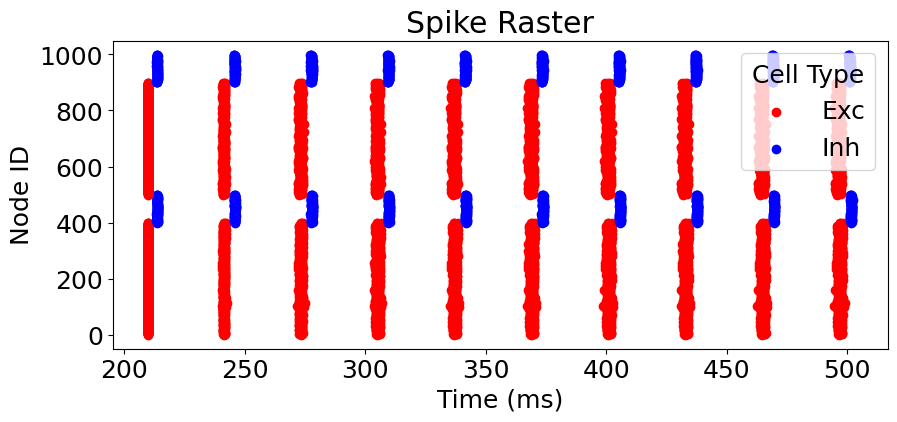

In [106]:
plt.rcParams.update({'font.size': 18})
# Plot the spike raster
with open("gid_info.json", "r") as file:
    gids = json.load(file)

fig, ax = plt.subplots(1, 1, figsize = (10, 4))

N_SPIKES_TO_PLOT = 10
N_NODES_TO_PLOT = np.max([len(np.array(gids['all_gids']).flatten()), 100])

for node_id in range(N_NODES_TO_PLOT):
    if node_id in gids["all_exc_gids"]:
        color = "red"; label = 'exc'
    elif node_id in gids["all_inh_gids"]:
        color = "blue"; label = 'inh'

    spikes_per_node = np.sort(spikes.get_times(node_id = node_id))[:N_SPIKES_TO_PLOT]
    sc = ax.scatter(spikes_per_node, [node_id] * len(spikes_per_node), c = color, label = label)

ax.set_ylabel("Node ID")
ax.set_xlabel("Time (ms)")
ax.set_title("Spike Raster")

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    [handles[labels.index("exc")], handles[labels.index("inh")]],
    ["Exc", "Inh"],
    loc = "upper right",
    title = "Cell Type")

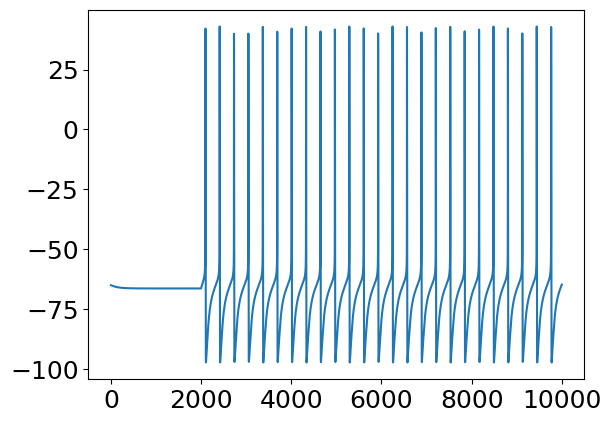

In [66]:
# Getting voltage outputs
import h5py
with h5py.File('output/v_report.h5', 'r') as file:
    retrieved_data = np.array(file['report']['PING-Assembly']['data'])
    retrieved_node_ids = np.array(file['report']['PING-Assembly']['mapping']['node_ids'])

# Figure out which neurons are in which assemblies. Each sublist corresponds to a new assembly
node_locations = json.load(open('gid_info.json'))['all_gids']

# Testing... plot one cell from region 1
plt.plot(retrieved_data[:, 0])

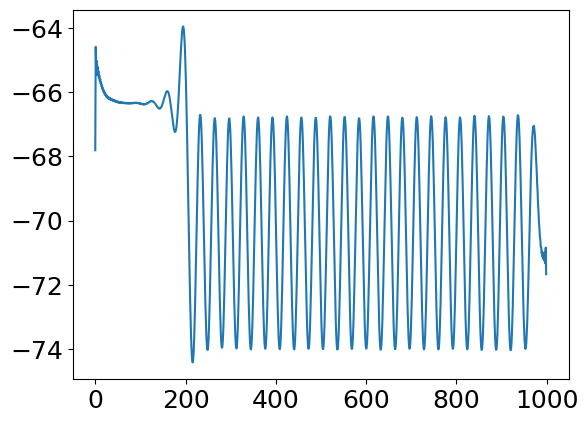

In [67]:
# Low pass filter

# Sampling frequency (Hz)
fs = int(retrieved_data.shape[0] / 0.1)

# Desired cutoff frequency of filter (Hz)
cutoff = 300     

# Filter order (typically, 5 or 6)
order = 6

sos = butter(6, cutoff * 2 / fs, btype = 'low', output = 'sos')
out = signal.sosfiltfilt(sos, retrieved_data, axis = 0)

# Resample to 1000 Hz
out = signal.resample(out, int(retrieved_data.shape[0] * 0.1), axis = 0)
fs = 1000 # new fs to use further

plt.plot(out[:, 0])

In [68]:
# Averaging across cells in each assembly at each timepoint. 

r1_avg = np.mean(out[:, :500], axis = 1)
r2_avg = np.mean(out[:, 500:], axis = 1)

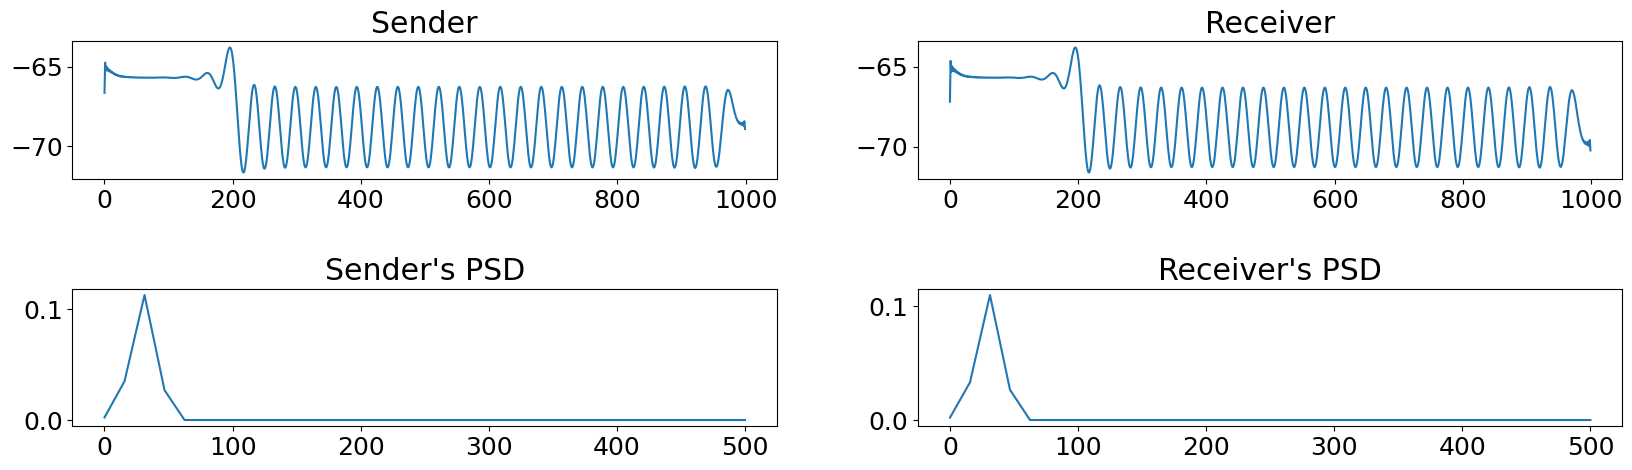

In [70]:
# Getting psds 
fig, ax = plt.subplots(2, 2, figsize = (20, 5))

ax.flatten()[0].plot(r1_avg)
ax.flatten()[0].set_title("Sender")

ax.flatten()[1].plot(r2_avg)
ax.flatten()[1].set_title("Receiver")

f, psd = signal.welch(r1_avg, fs=fs, nperseg=64)
ax.flatten()[2].plot(f, psd)
ax.flatten()[2].set_title("Sender's PSD")

f, psd = signal.welch(r2_avg, fs = fs, nperseg=64)
ax.flatten()[3].plot(f, psd)
ax.flatten()[3].set_title("Receiver's PSD")

fig.subplots_adjust(hspace = 0.8)

Text(0.5, 1.0, 'Coherence^2 between Sender and Receiver')

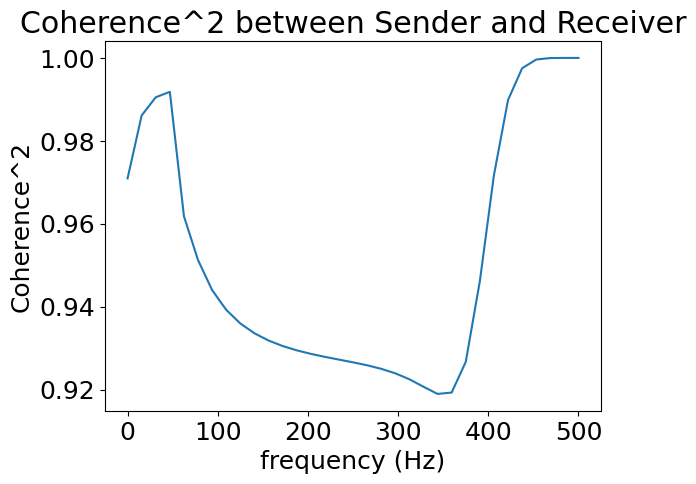

In [71]:
# Signal Coherence

f, coh2 = signal.coherence(r1_avg, r2_avg, fs=fs, nperseg=64)
plt.plot(f, coh2)
plt.xlabel('frequency (Hz)')
plt.ylabel('Coherence^2')
plt.title('Coherence^2 between Sender and Receiver')

## Source Porjection coherence

In [107]:
# Source Projection Coherence
# pick out only the cells with excitatory/inhibitory connections to the other regions

# Figure out which neurons are in which assemblies. Each sublist corresponds to a new assembly
node_locations = json.load(open('gid_info.json'))
print(node_locations.items())

dict_items([('all_gids', [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216

In [108]:
import h5py
from bmtk.analyzer import edges
with h5py.File('network/PING-Assembly_PING-Assembly_edges.h5', 'r') as file:
    # print(file['edges']['PING-Assembly_to_PING-Assembly']['source_node_id'])
    edges_df = edges.to_edges_dataframe(file['edges']['PING-Assembly_to_PING-Assembly'])

edges_df

,source_node_id,target_node_id,edge_type_id,nsyns
0,471,0,102,1
1,430,0,102,1
2,406,0,102,1
3,410,0,102,1
4,477,0,102,1
...,...,...,...,...
89859,764,999,103,1
89860,802,999,103,1
89861,894,999,103,1
89862,953,999,104,1


In [109]:
# Leave only sources from assembly 1
projecting_cell_ids = edges_df[(edges_df['source_node_id'].isin(node_locations['all_gids'][0]))]

# Leave only targets from assembly 2
projecting_cell_ids = projecting_cell_ids[(projecting_cell_ids['target_node_id'].isin(node_locations['all_gids'][1]))]

projecting_cell_ids.head()

,source_node_id,target_node_id,edge_type_id,nsyns
64691,2,900,106,1
64754,15,900,106,1
64756,14,900,106,1
64757,13,900,106,1
64758,12,900,106,1


In [110]:
len(projecting_cell_ids['source_node_id'].unique())

17

## Bibliography

[1] Börgers, C. (2017). An introduction to modeling neuronal dynamics (Vol. 66). Berlin: Springer.